In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys

# Add src to path
sys.path.append("src")
from sift import sift
from ransac import ransac
from stitch import stitch
from BWImage import BWImage
from GeometricTransforms import scale

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

# Introduction

In this lab we have a set of input images obtained from a planar scene and our goal to combine the images assuming homographic relation between each images.

There are two parts. 
* Part-1: Merge 3 given images.
* Part-2: Merge images taken by us.

#### Theory and notations.

In my implementations I deviate slightly from the algorithm and notation given in the problem statement. The reason is that my approach is easier to extend beyond 3 images.

Here $H_{2, 1}$ indicates the homography matrix used to obtain the coordinates of a point-i in image-2 that corresponds to point-i in image-1. This relation is given below.

$$
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
 =
H_{2,1}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

$$
\begin{bmatrix}
x^3_i\\
y^3_i
\end{bmatrix}
 =
H_{3,2}
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
$$

I introduce another notation. $H_j$ indicates the homographic relation between an image-j and image-1. For example to get the relation between image-3 and image-1 we go through image-2. We first use the relation between image-2 and image-3 via the homography $H_{3, 2}$ and then relate image-2 to image-1 via the homography $H_{2, 1}$.

$$
\begin{bmatrix}
x^2_i\\
y^2_i
\end{bmatrix}
 =
H_{2}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

$$
\begin{bmatrix}
x^3_i\\
y^3_i
\end{bmatrix}
 =
H_{3}
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

In general,

$$
\begin{bmatrix}
x^j_i\\
y^j_i
\end{bmatrix}
=
H_j
\begin{bmatrix}
x^1_i\\
y^1_i
\end{bmatrix}
$$

where $H_j = H_{j, j-1} \times H_{j-2, j-1} \times \cdots \times H_{2, 1}$ and we take $H_1 = I$, the identity matrix.

$H_j$ gives us the point w.r.t to the origin of image-j, that map to the point-j w.r.t the origin of image-1.

In addition to the homographic relation the coordinate of image-1 is translated w.r.t to the origin of the canvas, to better accomodate all the images.
The relation between point w.r.t these two coordinate systems is given by:
$$
\begin{bmatrix}
x^1_j\\
y^1_j\\
\end{bmatrix}
=
\begin{bmatrix}
x^c_j\\
y^c_j\\
\end{bmatrix}
-
\begin{bmatrix}
t_x\\
t_y
\end{bmatrix}
$$

#### Implementation

* `BWImage` class is same from my lab-1 assignment.
* `GeometricTransforms.py` contains scale function that was implemented in lab-1. This is used to reduces the size of the image taken from my camera.
* `sift.py` same as the one given to use.
* `ransac.py` Contains the implementation of ransac algorithm along with the functions to get homography based on 4 points and based on n points.
* `stitch.py` Contains `stitch` function that is used to combine the images taken from different views.
* `utils.py` Contains some utility functions such as to change between Cartesian and Homogenous coordinates.

#### Input data
* **Part-1**: The given images were used as such.
Files: `img1.png`, `img2.png` and `img3.png`.
* **Part-2**: I took pictures of a portrait in my room. I also tried to use some pictures of some building in our campus, but it did not work because the buildings were not approximtely flat form the distance where I took the picture. I could not find a good spot the was far enough to have an approximate flat image or some building that appeared flat enough even from a short distance. Because of this I took picture of a portrait in my room.

# Part-1: Merge images given to us.

#### Read input images and examine them.

In [2]:
# Read input images to a list imgs.
imgs = []
start_index = 1
num_images = 3
for i in range(start_index, num_images + start_index):
    imgs.append(cv.imread('data/input/img' + str(i) + '.png'))

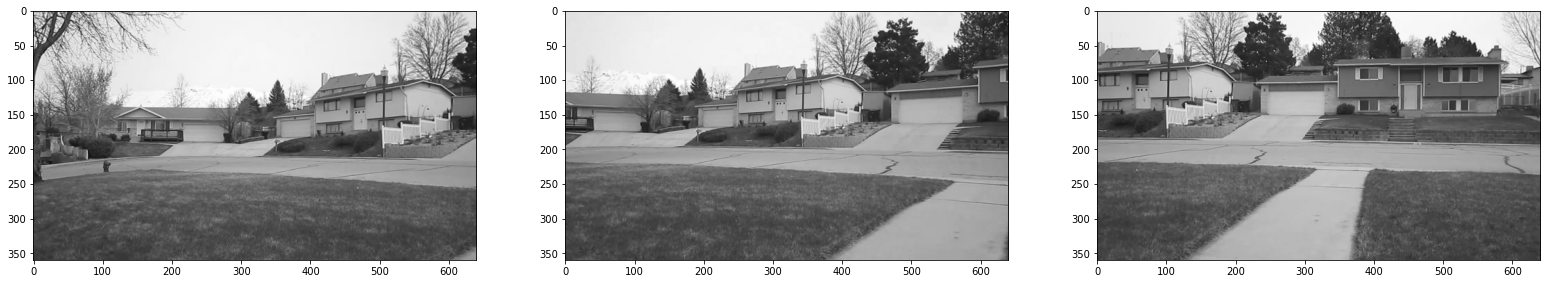

In [3]:
# Print the read images.
fig, ax = plt.subplots(1, num_images, figsize = (27, 15))
for i in range(num_images):
    ax[i].imshow(imgs[i])

#### Get point correspondences and solve the homography matrix.

In [4]:
## Get corresponding points and homographies.
# cpts -> Corresponding points.
cpts = []
# Homographies.
# H[i] = H_{i+2, i+1}. Homography to get img[i+1] from img[i].
# H[0] = H_{21}.
H = []
for i in range(num_images-1):
    cpts.append(sift(imgs[i+1], imgs[i]))
    H.append(ransac(cpts[i]))

# NOTE-1: Therefore, [xi, yi] = H[i] x H[i-1] x ... x [x1, y1].
# NOTE-2: Variable H is used in a different meaning in `stitch.py`.

[ WARN:0@1.213] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


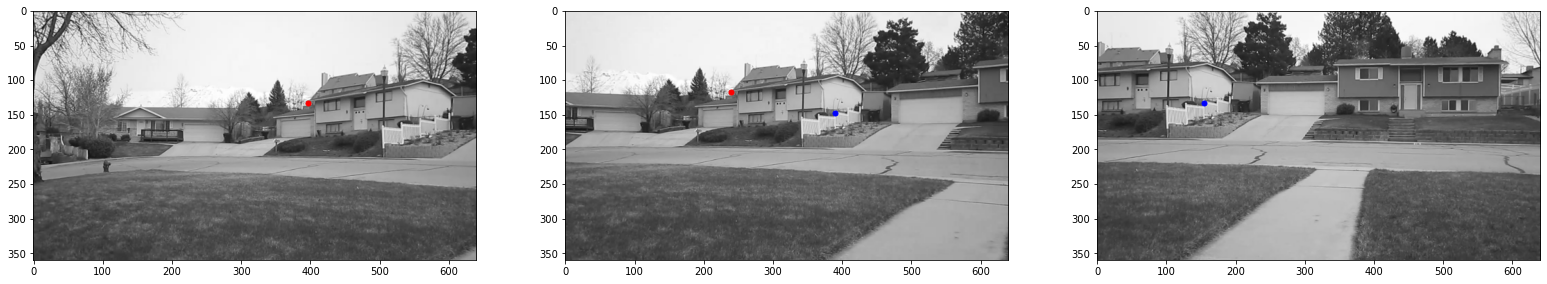

In [5]:
## View input images and a sample point correspondance.
fig, ax = plt.subplots(1, num_images, figsize = (27, 15))
for i in range(num_images):
    ax[i].imshow(imgs[i])

# Check homography with a random point.
_l, _k = 100, 100
ax[0].plot(cpts[0][1][_l][1], cpts[0][1][_l][0], marker='o', markersize=5, c='r')
ax[1].plot(cpts[0][0][_l][1], cpts[0][0][_l][0], marker='o', markersize=5, c='r')
ax[1].plot(cpts[1][1][_k][1], cpts[1][1][_k][0], marker='o', markersize=5, c='b')
ax[2].plot(cpts[1][0][_k][1], cpts[1][0][_k][0], marker='o', markersize=5, c='b')

#### Stitch images based on the homography matrices.

100%|██████████| 1000/1000 [01:13<00:00, 13.66it/s]


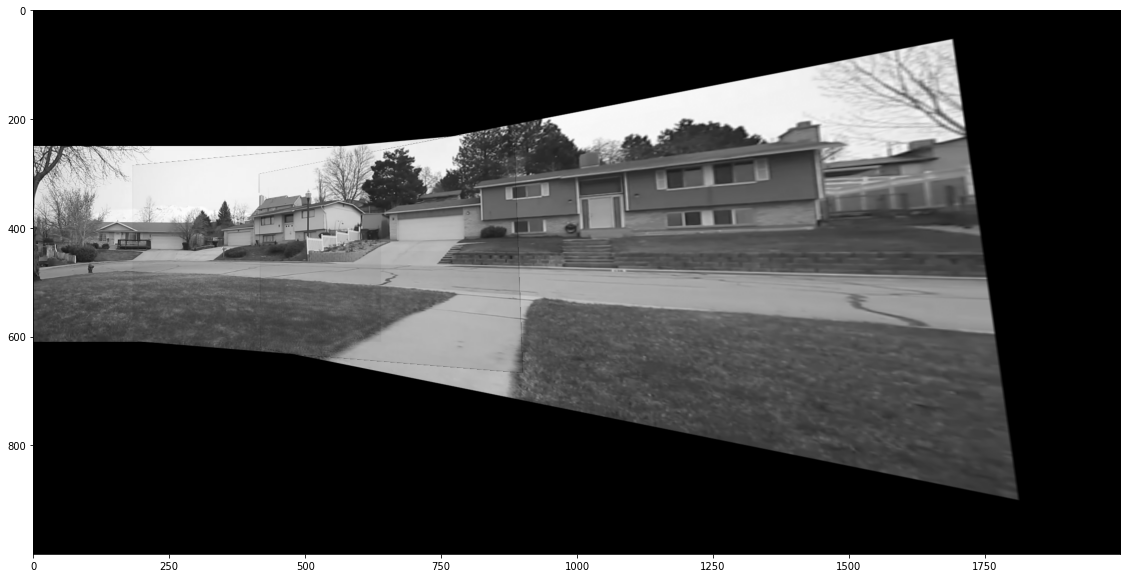

In [6]:
# Create a canvas
canvas = BWImage()
canvas.make_blank((1000, 2000))
img1_bw = BWImage(imgs[0])
img2_bw = BWImage(imgs[1])
img3_bw = BWImage(imgs[2])
I = np.eye(3)
stitch(canvas, [img1_bw, img2_bw, img3_bw], H, 250, 0)
plt.figure(figsize = (60, 10))
plt.imshow(canvas.get_image())
plt.savefig('data/output/merged_given.png')

# Part-2: Merge images taken from my phone.

#### Read and examine pictures taken from my phone.

In [7]:
imgs_hd = []
start_index = 10
num_images = 3

for i in range(start_index, num_images + start_index):
    imgs_hd.append(cv.imread('data/input/img' + str(i) + '.png'))

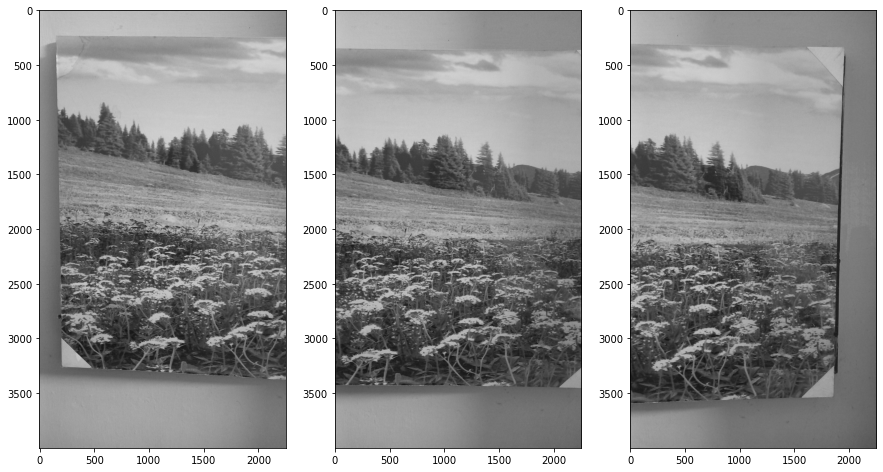

In [8]:
fig, ax = plt.subplots(1, num_images, figsize = (15, 27))
for i in range(num_images):
    ax[i].imshow(imgs_hd[i])

### Shrink image dimension.

In [9]:
imgs = []
h = 1000
s = h / imgs_hd[0].shape[0]
w = int(imgs_hd[0].shape[1] * s)
for i in range(num_images):
    img_hd = imgs_hd[i]
    bwimg_hd = BWImage(imgs_hd[i])
    bwimg = BWImage()
    bwimg.make_blank((h, w))
    scale(bwimg_hd, bwimg, s, s)
    imgs.append(bwimg.get_image().astype(np.uint8))

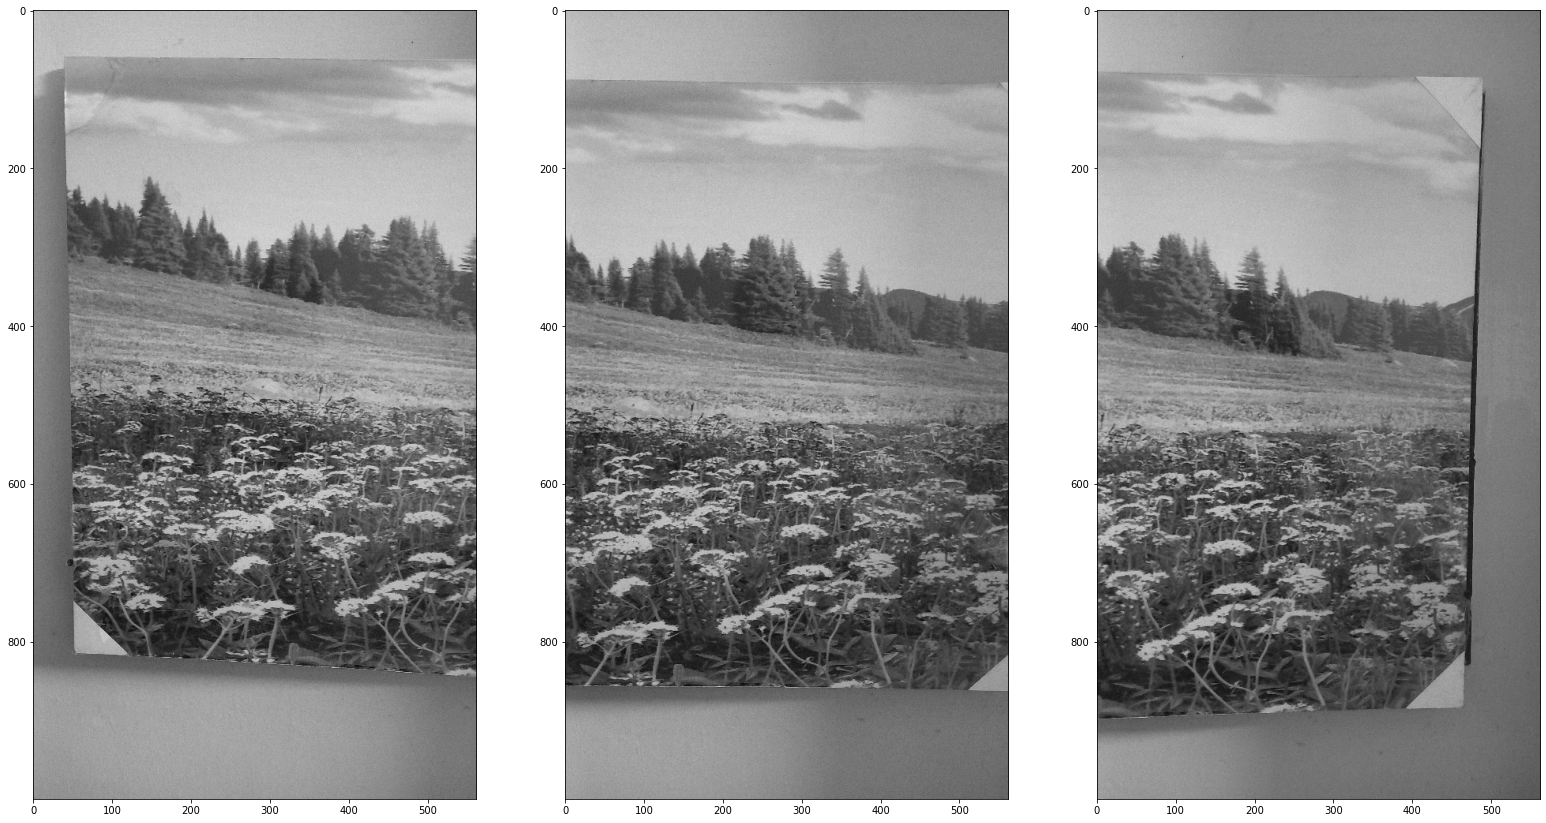

In [10]:
## View input images and a sample point correspondance.
fig, ax = plt.subplots(1, num_images, figsize = (27, 15))
for i in range(num_images):
    ax[i].imshow(imgs[i])

#### Get point-correspondences and homography.

In [11]:
## Get corresponding points and homographies.
# cpts -> Corresponding points.
cpts = []
# Homographies.
# H[i] = H_{i+2, i+1}. Homography to get img[i+1] from img[i].
# H[0] = H_{21}.
H = []
for i in range(num_images-1):
    cpts.append(sift(imgs[i+1], imgs[i]))
    H.append(ransac(cpts[i]))

print(cpts[0].shape)
print(cpts[1].shape)
# NOTE-1: Therefore, [xi, yi] = H[i] x H[i-1] x ... x [x1, y1].
# NOTE-2: Variable H is used in a different meaning in `stitch.py`.

(2, 1132, 2)
(2, 1137, 2)


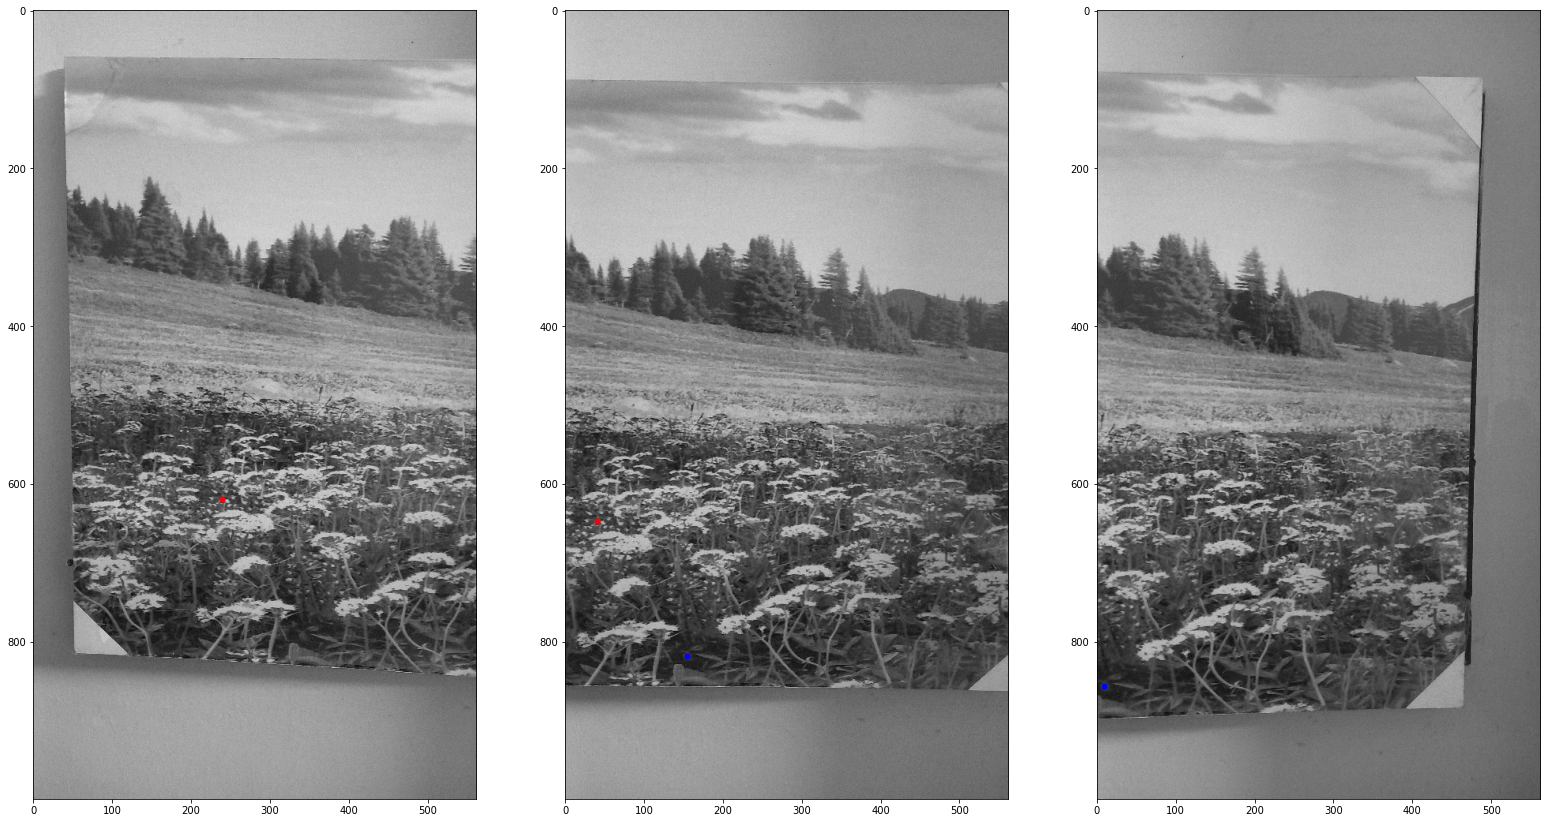

In [12]:
## View input images and a sample point correspondance.
fig, ax = plt.subplots(1, num_images, figsize = (27, 15))
for i in range(num_images):
    ax[i].imshow(imgs[i])

# Check homography with a random point.
_l, _k = 100, 8
ax[0].plot(cpts[0][1][_l][1], cpts[0][1][_l][0], marker='o', markersize=5, c='r')
ax[1].plot(cpts[0][0][_l][1], cpts[0][0][_l][0], marker='o', markersize=5, c='r')
ax[1].plot(cpts[1][1][_k][1], cpts[1][1][_k][0], marker='o', markersize=5, c='b')
ax[2].plot(cpts[1][0][_k][1], cpts[1][0][_k][0], marker='o', markersize=5, c='b')

In [13]:
from utils import to_cartesian
from utils import to_homogenous
i, j = 200, 200
_ = to_cartesian(H[0] @ to_homogenous(np.array([i, j]).reshape(2, 1)))
print(_)

[[223.35002748]
 [-22.06402554]]


  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:59<00:00, 20.22it/s]


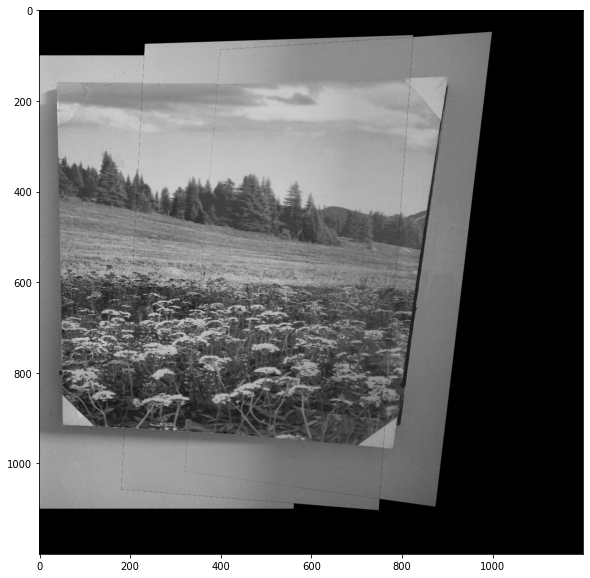

In [15]:
# Create a canvas
canvas = BWImage()
canvas.make_blank((1200, 1200))
img1_bw = BWImage(imgs[0])
img2_bw = BWImage(imgs[1])
img3_bw = BWImage(imgs[2])
I = np.eye(3)
stitch(canvas, [img1_bw, img2_bw, img3_bw], H, 100, 0)
plt.figure(figsize = (60, 10))
plt.imshow(canvas.get_image())
plt.savefig('data/output/merged_self.png')